# –í—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω—ã–π –∫–æ–¥

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HistoryPlotter:
    def __init__(self):
        # dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epo—Åhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epo—Åhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epo—Åhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epo—Åhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. plot
                ax[2].errorbar(
                    np.arange(history["epo—Åhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epo—Åhs"]))
                    ax[2].set_xticklabels(np.arange(history["epo—Åhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

# transforms for data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.13), (0.3))]
)

data_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
train_set, val_set = random_split(
    data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


In [ ]:
import torch.nn as nn

class SimpleMNIST_NN_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

In [ ]:
!pip install -q lightning tbparse
clear_output()

In [ ]:
import torch
import lightning as L


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

        # Additionally, we will save training logs ‚Äúmanually‚Äù
        # for visualization within the lecture. Please limit yourself
        # to the native training logging tools from PytorchLightning
        # when training your own models.
        self.history = {"loss_on_train": [], "loss_on_test": [], "model_name": exp_name}

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_train", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_train"].append(loss.cpu().detach().item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())

# –†–µ–∂–∏–º—ã –æ–±—É—á–µ–Ω–∏—è

–ù–∞–º –Ω–µ –æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ –ø–æ–¥–¥–µ—Ä–∂–∏–≤–∞—Ç—å –æ–¥–∏–Ω –∏ —Ç–æ—Ç –∂–µ `learning rate` –≤ —Ç–µ—á–µ–Ω–∏–µ –≤—Å–µ–≥–æ –æ–±—É—á–µ–Ω–∏—è. –ë–æ–ª–µ–µ —Ç–æ–≥–æ, –¥–ª—è —Ç–æ–≥–æ –∂–µ SGD –µ—Å—Ç—å –≥–∞—Ä–∞–Ω—Ç–∏–∏, —á—Ç–æ –µ—Å–ª–∏ –ø—Ä–∞–≤–∏–ª—å–Ω–æ –ø–æ–¥–æ–±—Ä–∞—Ç—å —Å—Ö–µ–º—É —É–º–µ–Ω—å—à–µ–Ω–∏—è `learning rate`, —Ç–æ –æ–Ω —Å–æ–π–¥–µ—Ç—Å—è –∫ –≥–ª–æ–±–∞–ª—å–Ω–æ–º—É –æ–ø—Ç–∏–º—É–º—É.

–ú—ã –º–æ–∂–µ–º –º–µ–Ω—è—Ç—å `learning rate` –ø–æ –Ω–µ–∫–æ—Ç–æ—Ä—ã–º –ø—Ä–∞–≤–∏–ª–∞–º.

## –†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞

–ò–Ω–æ–≥–¥–∞ –º—ã –º–æ–∂–µ–º —Å—Ç–∞–ª–∫–∏–≤–∞—Ç—å—Å—è —Å –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ–º —Å–µ—Ç–∏ ‚Äî –ø–æ—è–≤–ª–µ–Ω–∏–µ–º –º–æ–º–µ–Ω—Ç–∞, –∫–æ–≥–¥–∞ –∫–∞—á–µ—Å—Ç–≤–æ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ –Ω–∞—á–∏–Ω–∞–µ—Ç –ø–∞–¥–∞—Ç—å. –î–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –±–æ—Ä–æ—Ç—å—Å—è —Å —ç—Ç–∏–º, –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Ä–∞–Ω–Ω—é—é –æ—Å—Ç–∞–Ω–æ–≤–∫—É ‚Äî –ø—Ä–µ–∫—Ä–∞—â–µ–Ω–∏–µ –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏, –∫–æ–≥–¥–∞ –æ—à–∏–±–∫–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –Ω–∞—á–∞–ª–∞ —Ä–∞—Å—Ç–∏.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/early_stopping.png" width="500"></center>

–í Lightning –¥–ª—è —Ä–∞–Ω–Ω–µ–π –æ—Å—Ç–∞–Ω–æ–≤–∫–∏ —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω callback `EarlyStopping` [üõ†Ô∏è[doc]](https://lightning-ai.webpkgcache.com/doc/-/s/lightning.ai/docs/pytorch/stable//common/early_stopping.html):

```python
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


class LitModel(LightningModule):
    def validation_step(self, batch, batch_idx):
        loss = ...
        self.log("val_loss", loss)


model = LitModel()
trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
trainer.fit(model)
```



 –¢–∞–∫–∂–µ —Ö–æ—Ä–æ—à–∞—è –ø—Ä–∞–∫—Ç–∏–∫–∞ ‚Äî —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏:

 ```python
 # from L.pytorch.callbacks import ModelCheckpoint  # - doesn't work
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    # dirpath='best_ckp/'
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)
```

## –£–º–µ–Ω—å—à–µ–Ω–∏–µ —Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è –Ω–∞ –ø–ª–∞—Ç–æ

–ï—â–µ –æ–¥–Ω–∏–º –º–µ—Ç–æ–¥–æ–º —É–ª—É—á—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ –æ–±—É—á–µ–Ω–∏—è —è–≤–ª—è–µ—Ç—Å—è —É–º–µ–Ω—å—à–µ–Ω–∏–µ —Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è –Ω–∞ –ø–ª–∞—Ç–æ: –∫–æ–≥–¥–∞ –∑–Ω–∞—á–µ–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–µ –Ω–µ —É–ª—É—á—à–∞–µ—Ç—Å—è –∫–∞–∫–æ–µ-—Ç–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö (`patience`), —É–º–Ω–æ–∂–∞–µ–º `learning rate` –Ω–∞ –Ω–µ–∫–æ—Ç–æ—Ä–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ `factor` < 1).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/resnet_18_and_34_layers.png"  width="700"></center>
<center><em>–ì—Ä–∞—Ñ–∏–∫ –∏–∑–º–µ–Ω–µ–Ω–∏—è –æ—à–∏–±–∫–∏ –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ –¥–≤—É—Ö –º–æ–¥–∏—Ñ–∏–∫–∞—Ü–∏–π ResNet —Å 34 –∏ 18 —Å–ª–æ—è–º–∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ</em></center>

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.1, patience=5
)
```

–ü—Ä–∏–º–µ–Ω–∏–º –∫ –Ω–∞—à–µ–π –º–æ–¥–µ–ª–∏ (–≤—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∑–∞–Ω–∏–º–∞–µ—Ç ~ 5 –º–∏–Ω—É—Ç).

–†–µ–∞–ª–∏–∑—É–µ–º –Ω–∏–∂–µ –∫–æ–¥ –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏ –Ω–∞ —á–∏—Å—Ç–æ–º PyTorch, —á—Ç–æ–±—ã —Ä–∞–∑–æ–±—Ä–∞—Ç—å—Å—è —Å —Ç–µ–º, –∫–∞–∫ –∏–º–µ–Ω–Ω–æ –ø–ª–∞–Ω–∏—Ä–æ–≤—â–∏–∫ –æ–±—É—á–µ–Ω–∏—è –≤—Å—Ç—Ä–æ–µ–Ω –≤ –∞–ª–≥–æ—Ä–∏—Ç–º –æ–±—É—á–µ–Ω–∏—è.
–û—Ç–∫–∞–∑–∞–≤—à–∏—Å—å –≤—Ä–µ–º–µ–Ω–Ω–æ –æ—Ç Lightning, –º—ã –¥–æ–ª–∂–Ω—ã –±—É–¥–µ–º —è–≤–Ω–æ –ø–µ—Ä–µ–º–µ—â–∞—Ç—å –æ–±—ä–µ–∫—Ç—ã –º–µ–∂–¥—É CPU –∏ GPU, –∞ —Ç–∞–∫–∂–µ —Å–ª–µ–¥–∏—Ç—å –∑–∞ —Ç–µ–º, —á—Ç–æ –º—ã –≤–µ—Ä–Ω–æ –≤—ã–±—Ä–∞–ª–∏ —Ä–µ–∂–∏–º —Ä–∞–±–æ—Ç—ã `model.train()` –∏–ª–∏ `model.eval()`.

In [ ]:
# compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history


def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [ ]:
from tqdm.notebook import tqdm


def train_model_sep_scheduler(
    model, optimizer, scheduler, model_name=None, num_epochs=5
):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epo—Åhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        model.eval()
        val_loss, loss_on_test = validate(model, criterion, val_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        scheduler.step(val_loss)
    return train_history

In [ ]:
model = SimpleMNIST_NN_Batchnorm(n_layers=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.1, patience=1
)

model_name = "reduce_lr_on_plateu"

history = train_model_sep_scheduler(
    model, optimizer, scheduler, model_name=model_name, num_epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

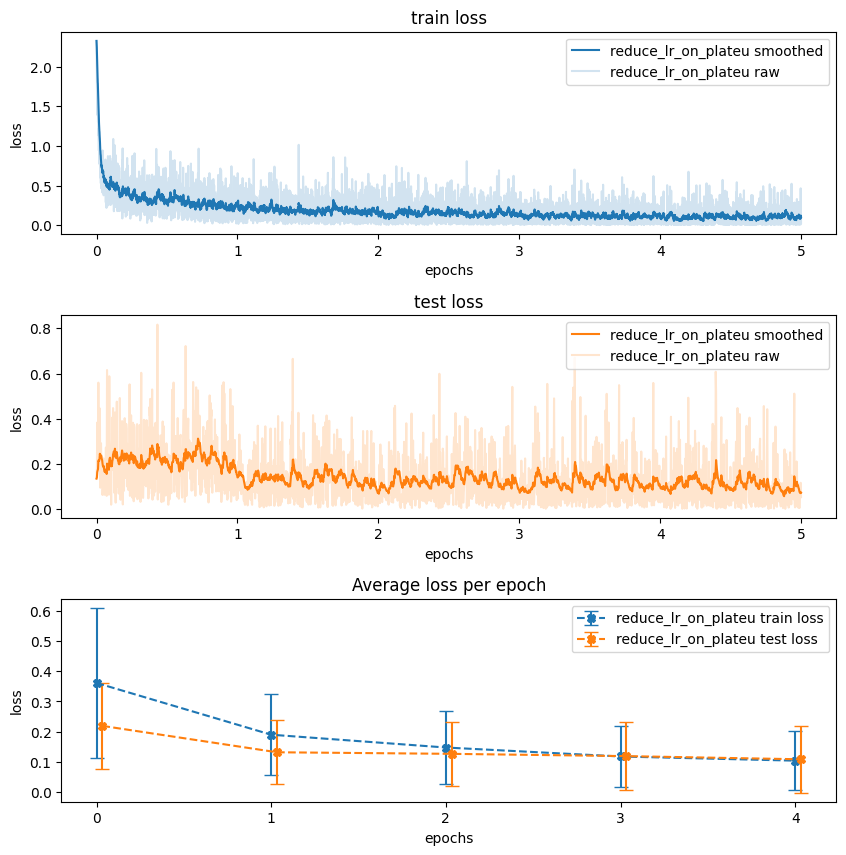

In [ ]:
history_plotter.add(history)
history_plotter.plot([model_name])

–î–ª—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ —Ä–∞–±–æ—Ç—ã –ø–ª–∞–Ω–∏—Ä–æ–≤—â–∏–∫–∞ –æ–±—É—á–µ–Ω–∏—è `ReduceLROnPlateau` –≤ —Ä–∞–º–∫–∞—Ö PyTorch Lightning –Ω–∞–º –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –ø–µ—Ä–µ–æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å –º–µ—Ç–æ–¥ `configure_optimizers` –∏ —É–∫–∞–∑–∞—Ç—å, –∑–∞ –∑–Ω–∞—á–µ–Ω–∏–µ–º –∫–∞–∫–æ–π –ª–æ–≥–∏—Ä—É–µ–º–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ "—Å–ª–µ–¥–∏—Ç—å" –≤–æ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è. –í—Å—è –æ—Å—Ç–∞–ª—å–Ω–∞—è –ª–æ–≥–∏–∫–∞ –±—É–¥–µ—Ç –≤—ã–ø–æ–ª–Ω–µ–Ω–∞ Lightning –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏.

In [ ]:
class PipelineWithScheduler(Pipeline):
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-9,
            factor=0.1,
            mode="min",
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "loss_on_test",
        }
        return [optimizer], [lr_scheduler]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())
        return {"loss_on_test", loss}

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

model_name = "reduce_lr_on_plateu_lightning"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = PipelineWithScheduler(
    model=model,
    exp_name=model_name,
    optimizer_class=torch.optim.Adam,
    optimizer_kwargs={
        "lr": 1e-2,
    },
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epo—Åhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


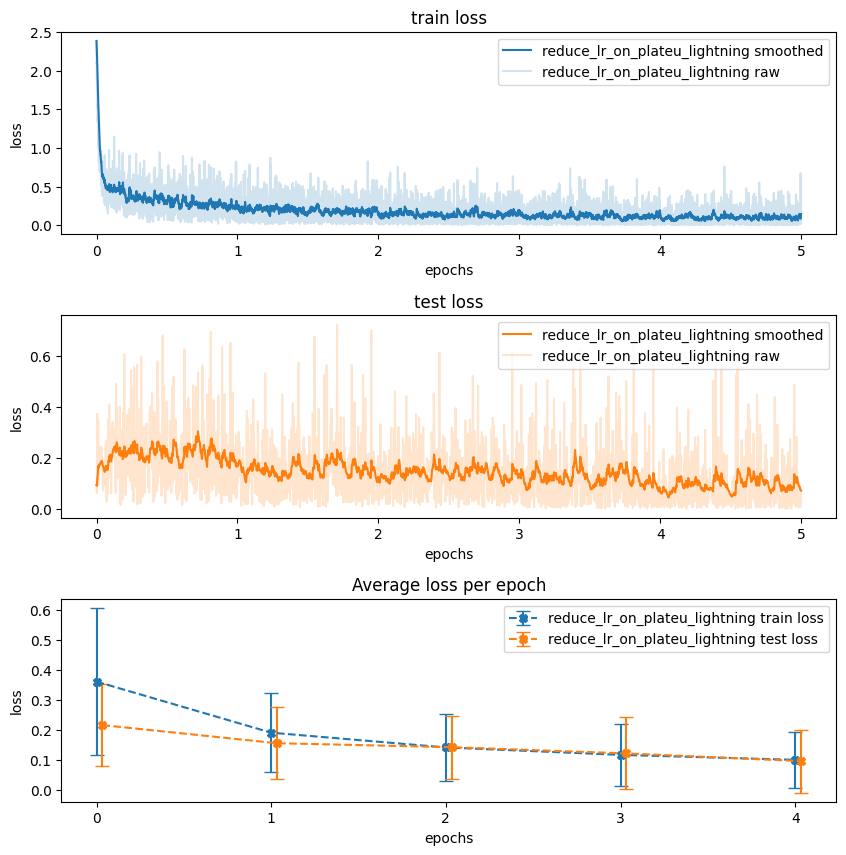

In [ ]:
history_plotter.plot([model_name])

## –ü–æ–Ω–∏–∂–µ–Ω–∏–µ —Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è –Ω–∞ –∫–∞–∂–¥–æ–π —ç–ø–æ—Ö–µ

–î–æ–º–Ω–æ–∂–∞—Ç—å `learning rate` –Ω–∞ `gamma` –∫–∞–∂–¥—É—é —ç–ø–æ—Ö—É:

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

## Neural Network WarmUp

–î–ª—è –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –±–æ–ª—å—à–∏—Ö –Ω–µ–π—Ä–æ–Ω–Ω—ã—Ö —Å–µ—Ç–µ–π –ø—Ä–∞–∫—Ç–∏–∫—É—é—Ç —Å–ª–µ–¥—É—é—â—É—é —Å—Ö–µ–º—É ([**gradual warmup** üéì[arxiv]](https://arxiv.org/pdf/1706.02677.pdf)):

1. –ü–æ—Å—Ç–∞–≤–∏—Ç—å –∏–∑–Ω–∞—á–∞–ª—å–Ω—ã–π `learning rate` –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ –Ω–∏–∂–µ —Ç–æ–≥–æ, —Å –∫–æ—Ç–æ—Ä–æ–≥–æ –º—ã –æ–±—ã—á–Ω–æ –Ω–∞—á–∏–Ω–∞–µ–º –æ–±—É—á–µ–Ω–∏–µ.
2. –ó–∞ –Ω–µ—Å–∫–æ–ª—å–∫–æ —ç–ø–æ—Ö, –Ω–∞–ø—Ä–∏–º–µ—Ä, 5, –¥–æ–≤–µ—Å—Ç–∏ `learning rate` –æ—Ç —ç—Ç–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è –¥–æ —Ç—Ä–µ–±—É–µ–º–æ–≥–æ. –¢–∞–∫ –º—ã –Ω–µ —Å–æ–≤–µ—Ä—à–∞–µ–º –±–æ–ª—å—à–∏—Ö —à–∞–≥–æ–≤, –∫–æ–≥–¥–∞ —Å–µ—Ç—å –µ—â–µ –Ω–∏—á–µ–≥–æ –Ω–µ –∑–Ω–∞–µ—Ç –æ –¥–∞–Ω–Ω—ã—Ö. –ó–∞ —Å—á–µ—Ç —ç—Ç–æ–≥–æ –Ω–µ–π—Ä–æ—Å–µ—Ç—å –ª—É—á—à–µ "–∞–¥–∞–ø—Ç–∏—Ä—É–µ—Ç—Å—è" –∫ –Ω–∞—à–∏–º –¥–∞–Ω–Ω—ã–º.

–¢–∞–∫–∂–µ —Ç–∞–∫–æ–π `learning schedule` –ø–æ–∑–≤–æ–ª—è–µ—Ç –∞–¥–∞–ø—Ç–∏–≤–Ω—ã–º –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞–º –ª—É—á—à–µ –æ—Ü–µ–Ω–∏—Ç—å –∑–Ω–∞—á–µ–Ω–∏—è `learning rate` –¥–ª—è —Ä–∞–∑–Ω—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/neural_network_warmup.png" width="1000"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1706.02677.pdf">Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour</a></em></center>


$kn$ –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏ ‚Äî —ç—Ç–æ —Ä–∞–∑–º–µ—Ä –æ–¥–Ω–æ–≥–æ –±–∞—Ç—á–∞.

## Cyclical learning schedule


[[arxiv] üéì Cyclical Learning Rates for Training Neural Networks (Smith, 2017)](https://arxiv.org/pdf/1506.01186.pdf)

**–ò–¥–µ—è:**
–§—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å –º–æ–∂–µ—Ç –∏–º–µ—Ç—å —Å–ª–æ–∂–Ω—ã–π –ª–∞–Ω–¥—à–∞—Ñ—Ç. –ù–∞–º –±—ã —Ö–æ—Ç–µ–ª–æ—Å—å:
* –∏–∑—É—á–∏—Ç—å –ø–æ–±–æ–ª—å—à–µ –ª–æ–∫–∞–ª—å–Ω—ã—Ö –º–∏–Ω–∏–º—É–º–æ–≤,
* –æ—Ü–µ–Ω–∏—Ç—å –∫–∞—á–µ—Å—Ç–≤–æ –≤ –∫–∞–∂–¥–æ–º –ª–æ–∫–∞–ª—å–Ω–æ–º –º–∏–Ω–∏–º—É–º–µ.


<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/Cyclic_LR_Schedule.png" width="750"></center>

<center><em>Source: <a href="https://openreview.net/pdf?id=BJYwwY9ll">Snapshot Ensembles: train 1, get M for free</a></em></center>

–î–ª—è —ç—Ç–æ–≥–æ –º—ã –º–æ–∂–µ–º –Ω–µ –≤—Å–µ –≤—Ä–µ–º—è –ø–æ–Ω–∏–∂–∞—Ç—å learning rate, –∞ –¥–µ–ª–∞—Ç—å —ç—Ç–æ **—Ü–∏–∫–ª–∏—á–µ—Å–∫–∏**: —Ç–æ –ø–æ–Ω–∏–∂–∞—Ç—å, —Ç–æ –ø–æ–≤—ã—à–∞—Ç—å.

–ü—Ä–∏ **—É–≤–µ–ª–∏—á–µ–Ω–∏–∏** learning rate –º–æ–¥–µ–ª—å –º–æ–∂–µ—Ç **–≤—ã–±—Ä–∞—Ç—å—Å—è** –∏–∑ –æ–¥–Ω–æ–≥–æ –ª–æ–∫–∞–ª—å–Ω–æ–≥–æ –º–∏–Ω–∏–º—É–º–∞. –ü—Ä–∏ **—É–º–µ–Ω—å—à–µ–Ω–∏–∏** ‚Äî **—Å–æ–π—Ç–∏—Å—å** –∫ —Å–ª–µ–¥—É—é—â–µ–º—É.


–ï—Å—Ç—å –¥–≤–µ –æ—Å–Ω–æ–≤–Ω—ã–µ –º–æ—Ç–∏–≤–∞—Ü–∏–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è **—Ü–∏–∫–ª–∏—á–µ—Å–∫–æ–≥–æ learning rate**:

* **–£—Å–∫–æ—Ä–µ–Ω–∏–µ —Å—Ö–æ–¥–∏–º–æ—Å—Ç–∏**: –º—ã —É–∂–µ –ø–æ—Å–º–æ—Ç—Ä–µ–ª–∏ –Ω–∞ –∞–¥–∞–ø—Ç–∏–≤–Ω—ã–µ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä—ã. –ò—Ö –Ω–µ–¥–æ—Å—Ç–∞—Ç–∫–æ–º —è–≤–ª—è–µ—Ç—Å—è –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ—Å—Ç—å —Ö—Ä–∞–Ω–µ–Ω–∏—è –≤ –ø–∞–º—è—Ç–∏ –∫–≤–∞–¥—Ä–∞—Ç–æ–≤ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤. –î–ª—è —Ü–∏–∫–ª–∏—á–µ—Å–∫–æ–≥–æ learning rate —ç—Ç–æ –Ω–µ–æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ, –µ–≥–æ –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Å SGD, –∏–∑–º–µ–Ω—è—è —Å–∫–æ—Ä–æ—Å—Ç–∏ –≤ 3‚Äì4 —Ä–∞–∑–∞. –ê–Ω–∞–ª–æ–≥–∏—á–Ω–æ —Å Adam ‚Äî —ç—Ç–æ –ø–æ–∑–≤–æ–ª–∏—Ç —Ä–µ–¥–∫–∏–º –ø—Ä–∏–∑–Ω–∞–∫–∞–º –±—ã—Å—Ç—Ä–µ–µ –æ–±—É—á–∞—Ç—å—Å—è (—á–∞—Å—Ç—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –±—É–¥—É—Ç –Ω–µ–º–Ω–æ–≥–æ ‚Äú–ª–æ–º–∞—Ç—å—Å—è‚Äù, –∞ –∑–∞—Ç–µ–º –≤–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞—Ç—å—Å—è). –î–ª—è —Ç–∞–∫–∏—Ö —Ü–µ–ª–µ–π –≤–∞–∂–Ω–æ –ø–æ–¥–±–∏—Ä–∞—Ç—å learning rate –≤–±–ª–∏–∑–∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ. –ò–¥–µ—è —ç—Ç–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∞ –≤ [—Å—Ç–∞—Ç—å–µ üéì[arxiv]](https://arxiv.org/pdf/1506.01186.pdf).

* **–°–æ–∑–¥–∞–Ω–∏–µ –∞–Ω—Å–∞–º–±–ª–µ–π –º–æ–¥–µ–ª–µ–π:** —Ä–∞–∑–Ω—ã–µ –ª–æ–∫–∞–ª—å–Ω—ã–µ –º–∏–Ω–∏–º—É–º—ã –±—É–¥—É—Ç –¥–∞–≤–∞—Ç—å –æ—à–∏–±–∫–∏ –Ω–∞ —Ä–∞–∑–Ω—ã—Ö –æ–±—ä–µ–∫—Ç–∞—Ö. –ú–æ–∂–Ω–æ —Å–æ—Ö—Ä–∞–Ω—è—Ç—å –º–æ–¥–µ–ª–∏ –≤ –ª–æ–∫–∞–ª—å–Ω—ã—Ö –º–∏–Ω–∏–º—É–º–∞—Ö –∏ –Ω–µ —Ç–æ–ª—å–∫–æ –∏—Å–∫–∞—Ç—å –ª—É—á—à—É—é, –Ω–æ –∏ —É—Å—Ç—Ä–∞–∏–≤–∞—Ç—å –º–µ–∂–¥—É –º–æ–¥–µ–ª—è–º–∏ –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏—è. –î–ª—è —ç—Ç–æ–≥–æ learning rate –∏–∑–º–µ–Ω—è—é—Ç –≤ —Å–æ—Ç–Ω–∏ —Ä–∞–∑. –ò–¥–µ—è —ç—Ç–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∞ –≤ [—Å—Ç–∞—Ç—å–µ üéì[article]](https://openreview.net/pdf?id=BJYwwY9ll). –û–±—ã—á–Ω–æ –¥–ª—è —Å–æ–∑–¥–∞–Ω–∏—è –∞–Ω—Å–∞–º–±–ª–µ–π –∏—Å–ø–æ–ª—å–∑—É—é—Ç [—Ü–∏–∫–ª–∏—á–µ—Å–∫–∏–π –æ—Ç–∂–∏–≥ üéì[arxiv]](https://arxiv.org/pdf/1608.03983.pdf).


 ### –£—Å–∫–æ—Ä–µ–Ω–∏–µ —Å—Ö–æ–¥–∏–º–æ—Å—Ç–∏

–î–æ–±–∞–≤–ª–µ–Ω–∏–µ ‚Äú–¥—Ä–æ–∂–∞–Ω–∏—è‚Äù –≤ learning rate [–ø—Ä–∏–¥—É–º–∞–Ω–æ üéì[arxiv]](https://arxiv.org/pdf/1506.01186.pdf) –∫–∞–∫ –∞–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–∞ Adam, –ø–æ–∑–≤–æ–ª—è—é—â–∞—è –Ω–µ —Ö—Ä–∞–Ω–∏—Ç—å –∑–Ω–∞—á–µ–Ω–∏—è Momentum –∏ —Å—É–º–º –∫–≤–∞–¥—Ä–∞—Ç–æ–≤ –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤ –ø—Ä–∏ –¥–µ—Ñ–∏—Ü–∏—Ç–µ –≤—ã—á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã—Ö –º–æ—â–Ω–æ—Å—Ç–µ–π. –ü–æ —Å—Ö–æ–¥–∏–º–æ—Å—Ç–∏ —ç—Ç–æ—Ç –º–µ—Ç–æ–¥ –ø–æ—á—Ç–∏ –≤—Å–µ–≥–¥–∞ —É—Å—Ç—É–ø–∞–µ—Ç Adam –∏ AdamW, –ø–æ—ç—Ç–æ–º—É —Ä–µ–¥–∫–æ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è.

–†–µ–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω–æ–π –∏–¥–µ–∏:

[[colab] ü•® –¶–∏–∫–ª–∏—á–µ—Å–∫–æ–µ –∏–∑–º–µ–Ω–µ–Ω–∏–µ learning rate –¥–ª—è —É—Å–∫–æ—Ä–µ–Ω–∏—è —Å—Ö–æ–¥–∏–º–æ—Å—Ç–∏](https://colab.research.google.com/drive/1DYfhoazJ9AGT0IFcBIybpM7wn3DEIoFm)

### –°–æ–∑–¥–∞–Ω–∏–µ –∞–Ω—Å–∞–º–±–ª–µ–π –º–æ–¥–µ–ª–µ–π

–î–ª—è —Å–æ–∑–¥–∞–Ω–∏—è –∞–Ω—Å–∞–º–±–ª–µ–π –º–æ–¥–µ–ª–µ–π learning rate —Ü–∏–∫–ª–∏—á–µ—Å–∫–∏ –∏–∑–º–µ–Ω—è—é—Ç –≤ —Å–æ—Ç–Ω–∏ —Ä–∞–∑ (–∞ –º–æ–∂–Ω–æ –∏ –¥–æ 0, –∫–∞–∫ –Ω–∏–∂–µ), –ø–æ—ç—Ç–æ–º—É –ø–æ–¥–±–æ—Ä –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è learning rate –Ω–µ –∫—Ä–∏—Ç–∏—á–µ–Ω. –í –∫–∞—á–µ—Å—Ç–≤–µ –ø—Ä–∞–≤–∏–ª–∞ –∏–∑–º–µ–Ω–µ–Ω–∏—è –∏—Å–ø–æ–ª—å–∑—É—é—Ç —Ü–∏–∫–ª–∏—á–µ—Å–∫–∏–π –æ—Ç–∂–∏–≥ (cosine annealing cycles):

$$\text{lr}(t) = \frac {\text{lr}_0}{2}(\cos(\frac{\pi\cdot \mod(t-1, [T/M])}{[T/M]})+1),$$

–≥–¥–µ $\text{lr}_0$ ‚Äî –Ω–∞—á–∞–ª—å–Ω–∞—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è, $T$ ‚Äî –æ–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏—Ç–µ—Ä–∞—Ü–∏–π, $M$ ‚Äî –æ–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–µ–π, $t$ ‚Äî —Ç–µ–∫—É—â–∞—è –∏—Ç–µ—Ä–∞—Ü–∏—è.

–í —Ñ–æ—Ä–º—É–ª—É –º–æ–∂–Ω–æ –¥–æ–±–∞–≤–∏—Ç—å –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ, –Ω–æ –º—ã —ç—Ç–æ –¥–µ–ª–∞—Ç—å –Ω–µ –±—É–¥–µ–º, —Ç.–∫. —ç—Ç–æ –Ω–µ –æ–±—è–∑–∞—Ç–µ–ª—å–Ω—ã–π –ø–∞—Ä–∞–º–µ—Ç—Ä.


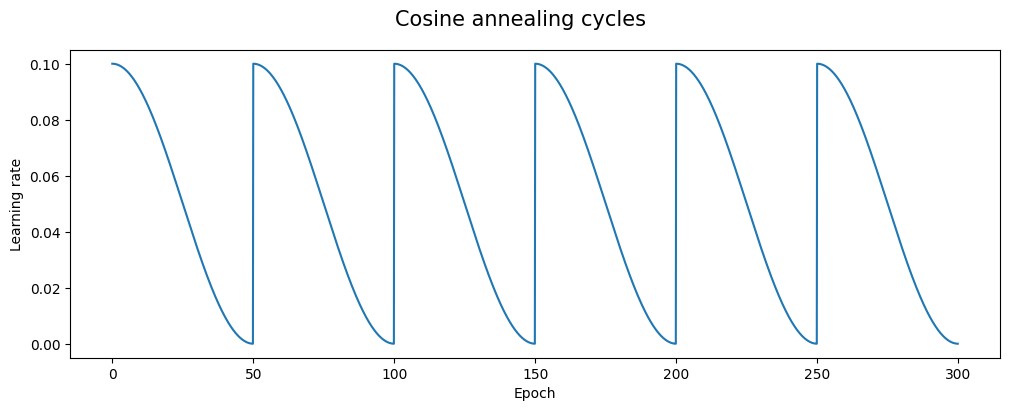

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# number of models (M in formula)
num_models = 6
# epoch per model
num_epochs = 50
# number of bats in dataset
len_dataset = 8

# total iteration number (T in formula)
total_iter = num_models * num_epochs * len_dataset

learning_rate_0 = 0.1

t = np.array(range(total_iter))
lr_t = (learning_rate_0 / 2) * (
    np.cos(np.pi * np.mod(t, total_iter / num_models) / (total_iter / num_models)) + 1
)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Cosine annealing cycles", size=15)
ax.plot(t / len_dataset, lr_t)
ax.set(xlabel="Epoch", ylabel="Learning rate")
plt.show()

–í PyTorch —Ü–∏–∫–ª–∏—á–µ—Å–∫–∏–π –æ—Ç–∂–∏–≥ —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –≤ –º–æ–¥—É–ª–µ `torch.optim.lr_scheduler.CosineAnnealingWarmRestarts`.

–û–±—â–µ–µ –ø—Ä–∞–≤–∏–ª–æ –ø–æ–¥–±–æ—Ä–∞ —Å–∫–æ—Ä–æ—Å—Ç–∏ –æ–±—É—á–µ–Ω–∏—è $\text{lr}_0$: –æ–Ω–∞ –¥–æ–ª–∂–Ω–∞ –±—ã—Ç—å –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –±–æ–ª—å—à–æ–π, —á—Ç–æ–±—ã ‚Äú–ª–æ–º–∞—Ç—å‚Äù –æ–±—É—á–µ–Ω–Ω—É—é –º–æ–¥–µ–ª—å, –ø—Ä–∏ —ç—Ç–æ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏ –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å –¥–æ—Å—Ç–∞—Ç–æ—á–Ω—ã–º –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –ø—Ä–∏–ª–∏—á–Ω–æ–≥–æ –∫–∞—á–µ—Å—Ç–≤–∞. –í [—Å—Ç–∞—Ç—å–µ üéì[article]](https://openreview.net/pdf?id=BJYwwY9ll), –Ω–∞–ø—Ä–∏–º–µ—Ä, –∏—Å–ø–æ–ª—å–∑—É—é—Ç 50 —ç–ø–æ—Ö, –Ω–æ —ç—Ç–æ –∑–Ω–∞—á–µ–Ω–∏–µ –∑–∞–≤–∏—Å–∏—Ç –æ—Ç –º–æ–¥–µ–ª–∏.

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=total_iter // num_models
)

Loss –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ –±—É–¥–µ—Ç –≤—ã–≥–ª—è–¥–µ—Ç—å –ø—Ä–∏–º–µ—Ä–Ω–æ —Ç–∞–∫ (–∫—Ä–∞—Å–Ω–∞—è –ª–∏–Ω–∏—è):

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/cosine_annealing_cycles.png" width="350"></center>

<center><em>Source: <a href="https://openreview.net/pdf?id=BJYwwY9ll">Snapshot Ensembles: train 1, get M for free</a></em></center>

–ú–æ–¥–µ–ª–∏ –≤ –∫–æ–Ω—Ü–µ —Ü–∏–∫–ª–∞ –æ—Ç–∂–∏–≥–∞ —Å–æ—Ö—Ä–∞–Ω—è—é—Ç—Å—è. –ú–æ–∂–Ω–æ –≤—ã–±—Ä–∞—Ç—å –ª—É—á—à—É—é –∏–ª–∏ –ø–æ—Å—Ç—Ä–æ–∏—Ç—å –∞–Ω—Å–∞–º–±–ª—å.


## Model soup

[[arxiv] üéì Model soups: averaging weights of multiple fine-tuned models improves accuracy without increasing inference time (2022)](https://arxiv.org/pdf/2203.05482.pdf)

–í —Å—Ç–∞—Ç—å–µ –±—ã–ª–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∞ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–∞—è –∏–¥–µ—è –∞–Ω—Å–∞–º–±–ª–∏—Ä–æ–≤–∞–Ω–∏—è –º–æ–¥–µ–ª–µ–π, –Ω–∞–∑–≤–∞–Ω–Ω–∞—è ‚Äú—Å—É–ø –º–æ–¥–µ–ª–µ–π‚Äù. –û–Ω–∞ –æ—á–µ–Ω—å –ø—Ä–æ—Å—Ç–∞: **–æ–±—É—á–∏—Ç—å –Ω–µ—Å–∫–æ–ª—å–∫–æ –º–æ–¥–µ–ª–µ–π** (–¥–ª—è —ç—Ç–æ–≥–æ –º—ã –±—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å **—Ü–∏–∫–ª–∏—á–µ—Å–∫–∏–π –æ—Ç–∂–∏–≥**) –∏ **–∞–≥—Ä–µ–≥–∏—Ä–æ–≤–∞—Ç—å –≤–µ—Å–∞ –º–æ–¥–µ–ª–µ–π**, –∫–æ—Ç–æ—Ä—ã–µ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—Ç –Ω–µ—Å–∫–æ–ª—å–∫–∏–º —Ä–∞–∑–ª–∏—á–Ω—ã–º –º–∏–Ω–∏–º—É–º–∞–º —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å, –≤ –æ–¥–Ω—É –º–æ–¥–µ–ª—å.

–î–ª—è ‚Äú–ø—Ä–∏–≥–æ—Ç–æ–≤–ª–µ–Ω–∏—è —Å—É–ø–∞‚Äù –≤–æ–∑—å–º–µ–º –¥–∞—Ç–∞—Å–µ—Ç –Ω–µ–º–Ω–æ–≥–æ —Å–ª–æ–∂–Ω–µ–µ, —á–µ–º MNIST, –∞ –∏–º–µ–Ω–Ω–æ CIFAR-10.

In [ ]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split


transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

cifar = datasets.CIFAR10("CIFAR10", train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10(
    "CIFAR10", train=False, download=True, transform=transform
)

train_set, val_set = random_split(cifar, [40_000, 10_000])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar_test, batch_size=256, shuffle=False, num_workers=2)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 170498071/170498071 [00:02<00:00, 80318589.84it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


–°–æ–±–µ—Ä–µ–º –ø—Ä–æ—Å—Ç—É—é –º–æ–¥–µ–ª—å:

In [ ]:
import torch.nn as nn


class SimpleNet_CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):  # input [batch, 3, 32, 32]
        x = self.activation(self.pool(self.conv1(x)))
        x = self.activation(self.pool(self.conv2(x)))
        x = self.activation(self.pool(self.conv3(x)))
        x = self.activation(self.fc1(x.flatten(start_dim=1)))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

–î–ª—è –æ–±—É—á–µ–Ω–∏—è –±—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å Lightning, –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ –º–µ—Ç—Ä–∏–∫ ‚Äî TorchMetrics. –≠—Ç–æ —Å–¥–µ–ª–∞–µ—Ç –∫–æ–¥ –±–æ–ª–µ–µ —É–Ω–∏–≤–µ—Ä—Å–∞–ª—å–Ω—ã–º (–µ–≥–æ –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –¥–ª—è –≤–∞—à–∏—Ö –º–æ–¥–µ–ª–µ–π —Å –º–∏–Ω–∏–º—É–º–æ–º –º–æ–¥–∏—Ñ–∏–∫–∞—Ü–∏–π).

–î–ª—è —á—Ç–µ–Ω–∏—è –ª–æ–≥–æ–≤ –±—É–¥–µ–º –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å tbparse.

In [ ]:
import matplotlib.pyplot as plt
from tbparse import SummaryReader
from IPython.display import clear_output


def visualization(log_dir):
    # visualization without TensorBoard for TensorBoard logs
    clear_output()
    reader = SummaryReader(log_dir)
    df = reader.scalars.drop_duplicates()

    uniq = set(df.tag.unique())
    uniq.remove("epoch")
    uniq = list(uniq)
    uniq.sort()

    i = 0
    ax_dict = {}
    for item in uniq:
        metric = item.split("/")[0]
        if metric not in ax_dict:
            ax_dict[metric] = i
            i += 1

    fig, axs = plt.subplots(len(ax_dict), 1, figsize=(12, 3.5 * len(ax_dict)))
    for item in uniq:
        metric = item.split("/")[0]
        ax = axs[ax_dict[metric]]
        sub_df = df[df["tag"] == item]
        ax.plot(sub_df.step, sub_df.value, label=item)
        ax.set_ylabel(metric)
        ax.legend()
        ax.set_xlabel("iter")
    plt.show()

–ï—Å—Ç—å [–Ω–µ—Å–∫–æ–ª—å–∫–æ –ø–æ–¥—Ö–æ–¥–æ–≤ üéì[arxiv]](https://arxiv.org/pdf/2203.05482.pdf) –∫ ‚Äú–ø—Ä–∏–≥–æ—Ç–æ–≤–ª–µ–Ω–∏—é —Å—É–ø–∞‚Äù. –ú—ã —Ä–∞—Å—Å–º–æ—Ç—Ä–∏–º –¥–≤–∞.

**Uniform soup** (—Ä–∞–≤–Ω–æ–º–µ—Ä–Ω—ã–π —Å—É–ø) ‚Äî –≤–µ—Å–∞ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π —Å—É–º–º–∏—Ä—É—é—Ç—Å—è —Å –æ–¥–∏–Ω–∞–∫–æ–≤—ã–º –≤–µ—Å–æ–º:
$$\text{Model} = f(x, \frac{1}{k}\sum_{i=1}^{k}œ¥_i)$$

**Greedy soup** (–∂–∞–¥–Ω—ã–π —Å—É–ø):
1. –ú–æ–¥–µ–ª–∏ —Å–æ—Ä—Ç–∏—Ä—É—é—Ç—Å—è –ø–æ —É–±—ã–≤–∞–Ω–∏—é –∫–∞—á–µ—Å—Ç–≤–∞ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π (–Ω–µ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π!!!) –≤—ã–±–æ—Ä–∫–µ.
2. –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å—Ç–∞–Ω–æ–≤–∏—Ç—Å—è –ø–µ—Ä–≤—ã–º ‚Äú–∏–Ω–≥—Ä–µ–¥–∏–µ–Ω—Ç–æ–º‚Äù —Å—É–ø–∞. –¢–µ–∫—É—â–µ–µ –∫–∞—á–µ—Å—Ç–≤–æ ‚Äú—Å—É–ø–∞‚Äù –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç—Å—è –ø–æ –∑–Ω–∞—á–µ–Ω–∏—é –º–µ—Ç—Ä–∏–∫–∏ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π (–Ω–µ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π!!!) –≤—ã–±–æ—Ä–∫–µ.
3. –û—Å—Ç–∞–ª—å–Ω—ã–µ –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –º–æ–¥–µ–ª–∏ –ø–æ –æ—á–µ—Ä–µ–¥–∏ –¥–æ–±–∞–≤–ª—è—é—Ç—Å—è –≤ —Å—É–ø. –ö–∞—á–µ—Å—Ç–≤–æ –Ω–æ–≤–æ–π –º–æ–¥–µ–ª–∏ –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç—Å—è –ø–æ –∑–Ω–∞—á–µ–Ω–∏—é –º–µ—Ç—Ä–∏–∫–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π (–Ω–µ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π!!!) –≤—ã–±–æ—Ä–∫–µ. –ï—Å–ª–∏ –∑–Ω–∞—á–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫–∏ –Ω–æ–≤–æ–π –º–æ–¥–µ–ª–∏ –ª—É—á—à–µ —Ç–µ–∫—É—â–µ–≥–æ –∫–∞—á–µ—Å—Ç–≤–∞ —Å—É–ø–∞, —Ç–æ –º–æ–¥–µ–ª—å –¥–æ–±–∞–≤–ª—è–µ—Ç—Å—è –≤ ‚Äú—Å—É–ø‚Äù, –∞ —Ç–µ–∫—É—â–∞—è –º–µ—Ç—Ä–∏–∫–∞ –æ–±–Ω–æ–≤–ª—è–µ—Ç—Å—è.

–ö–∞—á–µ—Å—Ç–≤–æ ‚Äú—Å—É–ø–∞‚Äù –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç—Å—è –ø–æ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ.

–ö–æ–¥ –¥–ª—è –º–µ—Ç–æ–¥–æ–≤ —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –Ω–∏–∂–µ. –î–ª—è –æ–±—É—á–µ–Ω–∏—è –æ—Ç–¥–µ–ª—å–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è —Ü–∏–∫–ª–∏—á–µ—Å–∫–∏–π –æ—Ç–∂–∏–≥.

In [ ]:
!mkdir ./soup_models_weights

In [ ]:
import lightning as L
from pathlib import Path
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassAUROC,
)


class MakeSoup(L.LightningModule):
    def __init__(
        self,
        model,
        num_class,
        n_cycle_iter,
        cycle_epochs,
        show=True,
        soup_path="./soup_models_weights",
    ):
        super().__init__()
        self.cycle_epochs = cycle_epochs
        self.num_class = num_class
        self.n_cycle_iter = n_cycle_iter
        self.model = model
        self.show = show

        self.criterion = torch.nn.CrossEntropyLoss()

        # set metrics
        self.metrics = MetricCollection(
            [
                MulticlassAccuracy(
                    num_classes=num_class,
                ),
                # MulticlassF1Score(num_classes=num_class,),
                # MulticlassAUROC(num_classes=num_class,)
            ]
        )

        self.train_metrics = self.metrics.clone(postfix="/train")
        self.val_metrics = self.metrics.clone(postfix="/val")
        self.models_data = []
        self.soup_path = Path(soup_path)

    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=0.01,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=self.n_cycle_iter,
            eta_min=0,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",  # or 'epoch'
                "frequency": 1,
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)

        self.log("loss/train", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.train_metrics.update(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log("loss/val", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.val_metrics.update(y_hat, y)

    def on_validation_epoch_end(self):
        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()
        if self.trainer.ckpt_path is not None:
            self.models_data.append(
                {
                    "path": self.trainer.ckpt_path,
                    "metrics": {
                        key: val.cpu().item() for key, val in val_metrics.items()
                    },
                }
            )

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        if self.show and self.current_epoch != 0:
            visualization(self.logger.log_dir)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        self.metrics.update(y_hat, y)

    def on_test_epoch_end(self):
        self.log_dict(self.metrics.compute())
        self.metrics.reset()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        predict = y_hat.argmax(dim=1).detach().cpu()
        true = y.detach().cpu()

        return {
            "predict_label": predict,
            "true_label": true,
        }

    def uniform_soup(self, skip_first=False):
        self.models_data.sort(key=lambda x: x["path"], reverse=True)
        if skip_first:
            models_data = self.models_data[1:].copy()
        else:
            models_data = self.models_data.copy()
        n_model = len(models_data)
        for i, item in enumerate(models_data):
            checkpoint = torch.load(
                item["path"], weights_only=True, map_location=self.device
            )["state_dict"]
            state_dict = {
                key.removeprefix("model."): val for key, val in checkpoint.items()
            }
            if i == 0:
                uniform_soup_params = {
                    key: val * (1.0 / float(n_model)) for key, val in state_dict.items()
                }
            else:
                uniform_soup_params = {
                    key: val * (1.0 / float(n_model)) + uniform_soup_params[key]
                    for key, val in state_dict.items()
                }
            print(f'Adding {item["path"]} to soup.')
        self.model.load_state_dict(uniform_soup_params)
        path = self.soup_path / "model_uniform_soup.pt"
        torch.save(
            self.model.state_dict(),
            path,
        )
        return self.model

    def greedy_soup(self, val_loader, metric="MulticlassAccuracy"):
        # sort
        self.models_data.sort(key=lambda x: x["metrics"][metric + "/val"], reverse=True)

        best_model_path = self.models_data[0]["path"]
        best_score = self.models_data[0]["metrics"][metric + "/val"]

        greedy_soup_ingredients = [best_model_path]

        checkpoint = torch.load(
            best_model_path, weights_only=True, map_location=self.device
        )["state_dict"]

        greedy_soup_params = {
            key.removeprefix("model."): val for key, val in checkpoint.items()
        }

        for i in range(1, len(self.models_data)):
            n = len(greedy_soup_ingredients)
            path = self.models_data[i]["path"]

            checkpoint = torch.load(path, weights_only=True, map_location=self.device)[
                "state_dict"
            ]

            ingredient_params = {
                key.removeprefix("model."): val for key, val in checkpoint.items()
            }

            # mix ingredient
            potential_greedy_soup_params = {
                k: greedy_soup_params[k].clone() * (n / (n + 1.0))
                + ingredient_params[k].clone() * (1.0 / (n + 1.0))
                for k in ingredient_params
            }

            self.val_metrics.reset()
            self.model.load_state_dict(potential_greedy_soup_params)
            # validate
            with torch.inference_mode():
                for batch_idx, batch in enumerate(val_loader):
                    self.test_step(batch, batch_idx)
                score = self.metrics.compute()[metric]
                self.metrics.reset()

            if score > best_score:
                greedy_soup_ingredients.append(path)
                best_score = score
                greedy_soup_params = potential_greedy_soup_params
                print(
                    f"Adding to soup. New soup is {greedy_soup_ingredients}. ",
                    f"With score = {best_score}",
                )

        self.model.load_state_dict(greedy_soup_params)
        path = self.soup_path / "model_greedy_soup.pt"
        torch.save(
            self.model.state_dict(),
            path,
        )
        return self.model

–ü–∞—Ä–∞–º–µ—Ç—Ä—ã –æ–±—É—á–µ–Ω–∏—è –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω—ã –Ω–∏–∂–µ. –ó–∞–ø—É—Å–∫ –æ–±—É—á–µ–Ω–∏—è –∑–∞–∫–æ–º–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω. –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –∑–∞–Ω–∏–º–∞–µ—Ç –ø—Ä–∏–º–µ—Ä–Ω–æ 30 –º–∏–Ω—É—Ç –Ω–∞ GPU.

In [ ]:
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

L.seed_everything(42)

n_model = 5
cycle_epochs = 20
num_class = 10

model = SimpleNet_CIFAR()

n_cycle_iter = cycle_epochs * len(train_loader)

pl_model = MakeSoup(model, num_class, n_cycle_iter, cycle_epochs)

lr_monitor = LearningRateMonitor(logging_interval="step")
save_checkpoint = ModelCheckpoint(
    every_n_epochs=cycle_epochs,
    save_top_k=n_model,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)

trainer = L.Trainer(
    max_epochs=cycle_epochs * n_model,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./log/"),
    callbacks=[lr_monitor, save_checkpoint],
)

# trainer.fit(pl_model, train_loader, val_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


–î–ª—è —É—Å–∫–æ—Ä–µ–Ω–∏—è —Ä–∞–±–æ—Ç—ã –º—ã –∑–∞–≥—Ä—É–∑–∏–º –∑–∞—Ä–∞–Ω–µ–µ –æ–±—É—á–µ–Ω–Ω—ã–µ –º–æ–¥–µ–ª–∏ –∏ –ª–æ–≥–∏ –æ–±—É—á–µ–Ω–∏—è:

In [ ]:
!wget -q https://ml.gan4x4.ru/msu/dev-2.2/L07/weights/model_soup_log.zip
!unzip -qq model_soup_log.zip

–ó–∞–≥—Ä—É–∑–∏–º –º–æ–¥–µ–ª–∏, –ø–æ—Å—á–∏—Ç–∞–µ–º —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –ø–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è–º –∏ —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –≤—ã–±–æ—Ä–∫–µ –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –∏ –∑–∞–≥—Ä—É–∑–∏–º –ø–æ—Å–ª–µ–¥–Ω–µ–µ –≤ –Ω—É–∂–Ω–æ–µ –ø–æ–ª–µ –º–æ–¥–µ–ª–∏. –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ª–æ–≥–∏ –æ–±—É—á–µ–Ω–∏—è.

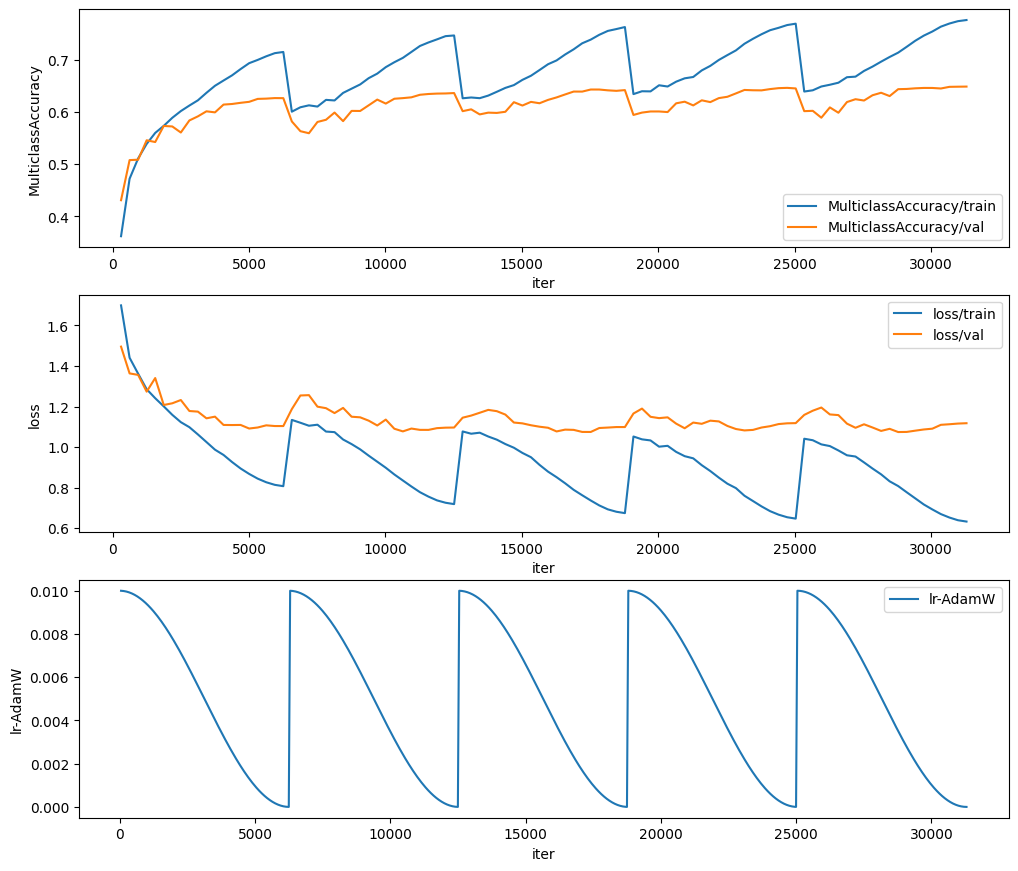

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ      Validate metric      ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ  MulticlassAccuracy/val   ‚îÇ     0.635899007320404     ‚îÇ
‚îÇ         loss/val          ‚îÇ    1.0963464975357056     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ      Validate metric      ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ  MulticlassAccuracy/val   ‚îÇ    0.6415534615516663     ‚îÇ
‚îÇ         loss/val          ‚îÇ    1.0986661911010742     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ      Validate metric      ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ  MulticlassAccuracy/val   ‚îÇ     0.644766092300415     ‚îÇ
‚îÇ         loss/val          ‚îÇ    1.1180671453475952     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ      Validate metric      ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ  MulticlassAccuracy/val   ‚îÇ    0.6482957005500793     ‚îÇ
‚îÇ         loss/val          ‚îÇ    1.1176204681396484     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ      Validate metric      ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ  MulticlassAccuracy/val   ‚îÇ    0.6261476278305054     ‚îÇ
‚îÇ         loss/val          ‚îÇ    1.1035901308059692     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [ ]:
import os
from warnings import simplefilter

simplefilter("ignore", category=RuntimeWarning)

visualization("/content/model_soup_log/log/lightning_logs/version_0")
weights_path = Path("/content/model_soup_log/log/lightning_logs/version_0/checkpoints/")
file_list = os.listdir(weights_path)
file_list.sort()

for f in file_list:
    path = weights_path / f

    trainer.validate(
        model=pl_model,
        dataloaders=val_loader,
        ckpt_path=path,
    )

–ú—ã —Å–æ—Ö—Ä–∞–Ω–∏–ª–∏ –ø—É—Ç–∏ –¥–æ –º–æ–¥–µ–ª–µ–π –∏ –∏—Ö —Ç–æ—á–Ω–æ—Å—Ç—å:

In [ ]:
pl_model.models_data

[{'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.635899007320404}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6415534615516663}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.644766092300415}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6482957005500793}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6261476278305054}}]

–ü–æ—Å—á–∏—Ç–∞–µ–º —Ç–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–µ–π –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ:

In [ ]:
for f in file_list:
    path = weights_path / f

    trainer.test(
        model=pl_model,
        dataloaders=test_loader,
        ckpt_path=path,
    )

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ        Test metric        ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ    MulticlassAccuracy     ‚îÇ    0.6317999958992004     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ        Test metric        ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ    MulticlassAccuracy     ‚îÇ    0.6402999758720398     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ        Test metric        ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ    MulticlassAccuracy     ‚îÇ    0.6462000012397766     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ        Test metric        ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ    MulticlassAccuracy     ‚îÇ    0.6441000699996948     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ        Test metric        ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ    MulticlassAccuracy     ‚îÇ    0.6267000436782837     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

–õ—É—á—à–∞—è –º–æ–¥–µ–ª—å –∏–º–µ–µ—Ç —Ç–æ—á–Ω–æ—Å—Ç—å $64.62\%$.

–ü–æ—Å—á–∏—Ç–∞–µ–º —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ –≤ —Å–ª—É—á–∞–µ –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏—è –º–æ–¥–µ–ª–µ–π (–≤—ã–±–∏—Ä–∞–µ—Ç—Å—è –∫–ª–∞—Å—Å, –∑–∞ –∫–æ—Ç–æ—Ä—ã–π –ø—Ä–æ–≥–æ–ª–æ—Å–æ–≤–∞–ª–æ –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ).

In [ ]:
import numpy as np


ans_statistic = np.zeros((n_model, len(cifar_test)))
true_label = np.zeros((len(cifar_test)))

for i, f in enumerate(file_list):
    path = weights_path / f

    prediction = trainer.predict(
        model=pl_model,
        dataloaders=test_loader,
        ckpt_path=path,
    )
    batch_size = prediction[0]["predict_label"].shape[0]
    for batsh_idx, items in enumerate(prediction):
        ans_statistic[i, batch_size * batsh_idx : batch_size * (batsh_idx + 1)] = items[
            "predict_label"
        ].numpy()
        true_label[batch_size * batsh_idx : batch_size * (batsh_idx + 1)] = items[
            "true_label"
        ].numpy()

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

–í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –Ω–∞—à–∏—Ö $5$ –º–æ–¥–µ–ª–µ–π –¥–ª—è –ø–µ—Ä–≤—ã—Ö $100$ –æ–±—ä–µ–∫—Ç–æ–≤ –≤—ã–±–æ—Ä–∫–∏ –¥–ª—è —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è. –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ –º–æ–¥–µ–ª–∏ –¥–∞—é—Ç —Ä–∞–∑–Ω—ã–µ –æ—Ç–≤–µ—Ç—ã, –∞ –∑–Ω–∞—á–∏—Ç –∏—Ö –º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –¥–ª—è –∞–Ω—Å–∞–º–±–ª—è.

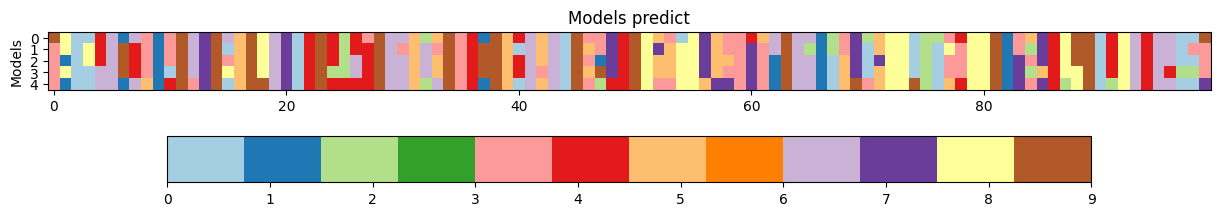

In [ ]:
plt.figure(figsize=(15, 4))
plt.imshow(ans_statistic[:, :100], cmap="Paired")
plt.colorbar(orientation="horizontal")
plt.title("Models predict")
plt.ylabel("Models")
plt.yticks(range(5))
plt.show()

In [ ]:
predict_label = np.zeros((len(cifar_test)))
for i in range(len(cifar_test)):
    values, counts = np.unique(ans_statistic[:, i], return_counts=True)
    predict_label[i] = values[counts.argmax()]
predict_label

array([3., 8., 0., ..., 5., 0., 7.])

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Ensemble accuracy {accuracy_score(true_label, predict_label)}")

Ensemble accuracy 0.6567


–ì–æ–ª–æ—Å–æ–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–µ–π –¥–∞–µ—Ç —Ç–æ—á–Ω–æ—Å—Ç—å $65.67\%$. –ù–∞ $1.05\%$ –ª—É—á—à–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏, –Ω–æ –ø—Ä–∏ —ç—Ç–æ–º –Ω–∞ $1$ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ —É—Ö–æ–¥–∏—Ç –≤ $5$ —Ä–∞–∑ –±–æ–ª—å—à–µ –≤—ã—á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã—Ö —Ä–µ—Å—É—Ä—Å–æ–≤.

–ü–æ–ø—Ä–æ–±—É–µ–º –ø—Ä–∏–º–µ–Ω–∏—Ç—å `uniform_soup`:

In [ ]:
model = pl_model.uniform_soup()
trainer.test(pl_model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt to soup.


Testing: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ        Test metric        ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ    MulticlassAccuracy     ‚îÇ    0.6455999612808228     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

[{'MulticlassAccuracy': 0.6455999612808228}]

–¢–æ—á–Ω–æ—Å—Ç—å —Ö—É–∂–µ. –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –Ω–∞—à–∏ –º–æ–¥–µ–ª–∏: –ø–µ—Ä–≤–∞—è –º–æ–¥–µ–ª—å –∏–º–µ–µ—Ç —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∏–∂–µ, —á–µ–º –æ—Å—Ç–∞–ª—å–Ω—ã–µ. –≠—Ç–æ —Å–≤—è–∑–∞–Ω–æ —Å —Ç–µ–º, —á—Ç–æ –æ–Ω–∞ —Å—Ç–∞—Ä—Ç–æ–≤–∞–ª–∞ —Å —Ö—É–¥—à–µ–π –ø–æ–∑–∏—Ü–∏–∏.

–£–±–µ—Ä–µ–º —ç—Ç—É –º–æ–¥–µ–ª—å –∏–∑ —Å—É–ø–∞:

In [ ]:
model = pl_model.uniform_soup(skip_first=True)
trainer.test(pl_model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt to soup.


Testing: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ        Test metric        ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ    MulticlassAccuracy     ‚îÇ    0.6483999490737915     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

[{'MulticlassAccuracy': 0.6483999490737915}]

–ü–æ–ª—É—á–∏–ª–∏ —Ç–æ—á–Ω–æ—Å—Ç—å $64.84\%$. –ù–∞ $0.22\%$ –ª—É—á—à–µ, —á–µ–º —É –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ –∏ –Ω–∞ $0.83\%$ –º–µ–Ω—å—à–µ, —á–µ–º —É –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏—è. –ü—Ä–∏ —ç—Ç–æ–º –º–æ–¥–µ–ª—å –ø—Ä–æ–≥–æ–Ω—è–µ—Ç—Å—è —Ç–æ–ª—å–∫–æ $1$ —Ä–∞–∑.

–ü–æ–ø—Ä–æ–±—É–µ–º `greedy_soup`:

In [ ]:
model = pl_model.greedy_soup(val_loader)
trainer.test(pl_model, test_loader)

Adding to soup. New soup is [PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt'), PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt')].  With score = 0.6521247029304504


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ        Test metric        ‚îÉ       DataLoader 0        ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ    MulticlassAccuracy     ‚îÇ    0.6484999656677246     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

[{'MulticlassAccuracy': 0.6484999656677246}]

–ü–æ–ª—É—á–∏–ª–∏ —Ç–æ—á–Ω–æ—Å—Ç—å $64.85\%$. –≠—Ç–æ –Ω–∞ $0.23\%$ –ª—É—á—à–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ –∏ –Ω–∞ $0.82\%$ —Ö—É–∂–µ –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏—è. –ü—Ä–∏ —ç—Ç–æ–º –º–æ–¥–µ–ª—å –ø—Ä–æ–≥–æ–Ω—è–µ—Ç—Å—è —Ç–æ–ª—å–∫–æ $1$ —Ä–∞–∑.

–¢–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º, —Å—É–ø –º–æ–¥–µ–ª–µ–π —è–≤–ª—è–µ—Ç—Å—è –∞–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–æ–π –∞–Ω—Å–∞–º–±–ª–∏—Ä–æ–≤–∞–Ω–∏—é –º–µ—Ç–æ–¥–æ–º –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏—è, –ø–æ–∑–≤–æ–ª—è—é—â–µ–π –ø–æ–¥–Ω—è—Ç—å —Ç–æ—á–Ω–æ—Å—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –±–µ–∑ —É–≤–µ–ª–∏—á–µ–Ω–∏—è –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã—Ö –¥–ª—è Inference –≤—ã—á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã—Ö —Ä–µ—Å—É—Ä—Å–æ–≤.

## –í–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–µ learning schedule –∏ –∞–¥–∞–ø—Ç–∏–≤–Ω–æ–≥–æ –∏–∑–º–µ–Ω–µ–Ω–∏—è learning rate

–ò —Ç–æ, –∏ –¥—Ä—É–≥–æ–µ –º–µ–Ω—è–µ—Ç `learning rate`:

* `learning scheduler` ‚Äî –≥–ª–æ–±–∞–ª—å–Ω–æ,

* –∞–¥–∞–ø—Ç–∏–≤–Ω—ã–µ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä—ã ‚Äî –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –≤–µ—Å–∞ –æ—Ç–¥–µ–ª—å–Ω–æ.

–ß–∞—Å—Ç–æ –∏—Ö –ø—Ä–∏–º–µ–Ω—è—é—Ç –≤–º–µ—Å—Ç–µ, –æ—Å–æ–±–µ–Ω–Ω–æ –≤ —Å–ª—É—á–∞–µ –∫—Ä–∏—Ç–µ—Ä–∏—è —Ä–∞–Ω–Ω–µ–π –æ—Å—Ç–∞–Ω–æ–≤–∫–∏ –∏ WarmUp.

–û–¥–Ω–∞–∫–æ –≤ —Å–ª—É—á–∞–µ —Ü–∏–∫–ª–∏—á–µ—Å–∫–æ–≥–æ —Ä–µ–∂–∏–º–∞ –æ–±—É—á–µ–Ω–∏—è —Ç–∞–∫ –¥–µ–ª–∞—é—Ç –Ω–µ –≤—Å–µ–≥–¥–∞. –î–µ–ª–æ –≤ —Ç–æ–º, —á—Ç–æ –æ–¥–Ω–∞ –∏–∑ –µ–≥–æ –∑–∞–¥–∞—á ‚Äî –∫–∞–∫ —Ä–∞–∑ –∏–∑–±–µ–∂–∞—Ç—å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –∞–¥–∞–ø—Ç–∏–≤–Ω—ã—Ö –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–æ–≤, —Ç—Ä–µ–±—É—é—â–∏—Ö –±–æ–ª—å—à–µ –ø–∞–º—è—Ç–∏ –∏ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã—Ö –≤—ã—á–∏—Å–ª–µ–Ω–∏–π.

–ü—Ä–∏ —ç—Ç–æ–º –Ω–∏–∫–∞–∫–∏—Ö –ø—Ä–µ–ø—è—Ç—Å—Ç–≤–∏–π –∫ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—é —Ç–æ–≥–æ –∂–µ Adam –≤ –∫–æ–º–ø–∞–Ω–∏–∏ –≤–º–µ—Å—Ç–µ —Å —Ü–∏–∫–ª–∏—á–µ—Å–∫–∏–º —Ä–µ–∂–∏–º–æ–º –æ–±—É—á–µ–Ω–∏—è –Ω–µ—Ç. –¢–∞–∫ –¥–µ–ª–∞—é—Ç, –Ω–∞–ø—Ä–∏–º–µ—Ä, –≤ [—Å—Ç–∞—Ç—å–µ üéì[arxiv]](https://arxiv.org/pdf/2004.02401.pdf).

–ö—Ä–æ–º–µ —Ç–æ–≥–æ, –µ—Å—Ç—å —Å–ª–æ–∂–Ω—ã–µ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä—ã, —Å–æ—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã–µ –∏–∑ –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö –ø—Ä–æ—Å—Ç—ã—Ö –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–æ–≤ –∏ —à–µ–¥—É–ª–µ—Ä–æ–≤. –ù–∞–ø—Ä–∏–º–µ—Ä, –µ—Å—Ç—å –ø—Ä–æ–µ–∫—Ç [Ranger21 üêæ[git]](https://github.com/lessw2020/Ranger21), –Ω–µ –ø–æ–ª—É—á–∏–≤—à–∏–π –æ—Ñ–æ—Ä–º–ª–µ–Ω–∏—è –≤ –≤–∏–¥–µ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏ –Ω–∞ [PyPi üõ†Ô∏è[doc]](https://pypi.org/), –∞–≤—Ç–æ—Ä—ã –∫–æ—Ç–æ—Ä–æ–≥–æ –ø—ã—Ç–∞—é—Ç—Å—è ‚Äú–ø–æ–º–µ—Ä–∏—Ç—å‚Äù —Ä–∞–∑–Ω—ã–µ –∏–¥–µ–∏ –∏–∑ —Å—Ç–∞—Ç–µ–π.

[[arxiv] üéì Ranger21: A Synergistic Deep Learning Optimizer (Wright, Demeure, 2021)](https://arxiv.org/pdf/2106.13731.pdf)

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/ranger21.png" width="700"></center>

<center><em>Loss –∏ accuracy –ø—Ä–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ Adam –∏ Ranger21 –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏ ResNet50 –Ω–∞ –Ω–∞–±–æ—Ä–µ –¥–∞–Ω–Ω—ã—Ö ImageNet</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2106.13731.pdf">Ranger21: A Synergistic Deep Learning Optimizer</a></em></center>

–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤—ã–≥–ª—è–¥—è—Ç –Ω–µ–ø–ª–æ—Ö–æ. –ù–µ–¥–æ—Å—Ç–∞—Ç–∫–æ–º —ç—Ç–æ–≥–æ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ —è–≤–ª—è–µ—Ç—Å—è –±–æ–ª—å—à–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ö—Ä–∞–Ω–∏–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤, –∞ —Ç–∞–∫–∂–µ —Ç–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –Ω–∞ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–Ω–æ–º —á–∏—Å–ª–µ –º–æ–¥–µ–ª–µ–π.